# Mercy Rule? Predicting the Full Time Result from the Half Time Result in the English Premier League

In [15]:
rm(list=ls()) # Clearing environment

ipak <- function(pkg){ # Function for installing and loading packages
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg))
      install.packages(new.pkg, dependencies = TRUE)
    sapply(pkg, require, character.only = TRUE)
  }
packages <- c("tidyverse",
			 "ggthemes",
			 "tree")
ipak(packages)

soccer <- read_csv('data/soccer18-19.csv.gz', show_col_types = FALSE) # Loading in data

tidyverse  ggthemes      tree 
     TRUE      TRUE      TRUE

## 1. Executive Summary

A team in the English Premier League has signed some young players. In order to optimize their playing time, the coach wants to be able to predict full time result at half time, so if the game is already won (or lost) the young players can see the field. To determine how predictable full time result is at half time, this research analyzes data from every match of the 2018/2019 Premier League season. Cross-tabulations, data visualization, and statistical inference reveal that full time result is indeed related to half time result, the home team wins more often than not, and the point of the season does not influence the probability of a certain full time result. A machine learning model - a decision tree for classification - is trained to incorporate these findings with other match statistics to best predict full time result. The model visualizes as a flowchart that the coach can easily trace based on match characteristics and predicts home wins well, away wins moderately well, and draws poorly. Overall, the findings of this analysis combined with the coach's subject matter expertise will optimize the amount of development time for the new young players. 

## 2. Introduction

The English Premier League is the most widely watched soccer league in the world. Each year, the twenty best teams in England and Wales play a 38 game round-robin, with the best performing team over these 38 games crowned champion. A team in the league has signed some younger players, and wants to know how predictive full time result is at half time. If the coach can have confidence that the game is won (or lost) by half time, they can give playing time to these younger players, helping them to develop. 

In this project, I determine how predictive full time result is from half time result and other match statistics using data from the 2018/2019 English Premier League season. I first explore the association between full time result and various features using descriptive statistics, data visualization, and statistical inference. I then build a decision tree for classification, utilizing all of the information from the features to make the best prediction of full time result.

## 3. Data

Data from the 2018/2019 English Premier League season is used for this analysis. It's important to note that the 2018/2019 season is the last season of the Premier League before the COVID-19 pandemic upended the league (and world) in March 2020. The data is from DataCamp Workspace, originally from https://data.world/chas/2018-2019-premier-league-matches. Each row in the dataset is a match, with the following variables available:

| Column     | Explanation                    |
| ---------- | ------------------------------ |
| Div        | Division the game was played in             |
| Date       | The date the game was played            |
| HomeTeam   | The home team  |
| AwayTeam   | The away team            |
| FTHG       | Full time home goals |
| FTAG       | Full time away goals |
| FTR        | Full time result |
| HTHG       | Half time home goals |
| HTAG       | Half time away goals |
| HTR        | Half time result |
| Referee    | The referee of the game |
| HS         | Number of shots taken by home team |
| AS         | Number of shots taken by away team |
| HST        | Number of shots taken by home team on target |
| AST        | Number of shots taken by away team on target |
| HF         | Number of fouls made by home team |
| AF         | Number of fouls made by away team |
| HC         | Number of corners taken by home team |
| AC         | Number of corners taken by away team |
| HY         | Number of yellow cards received by home team |
| AY         | Number of yellow cards received by away team | 
| HR         | Number of red cards received by home team |
| AR         | Number of red cards received by away team |

In [16]:
# Converting Date to Month
soccer <- soccer %>%
	mutate(Month = month(date(soccer$Date)))

# Converting full time match statistics to half time match statistics
soccer <- soccer %>%
	mutate(HS = HS / 2,
		  AS = AS / 2,
		  HST = HST / 2,
		  AST = AST /2,
		  HF = HF / 2,
		  AF = AF / 2,
		  HC = HC / 2,
		  AC = AC / 2,
		  HY = HY / 2,
		  AY = AY / 2,
		  HR = HR / 2,
		  AR = AR / 2)

# Factoring appropriate variables
soccer <- soccer %>%
	mutate(HomeTeam = factor(HomeTeam),
		  AwayTeam = factor(AwayTeam),
		  FTR = factor(FTR),
		  HTR = factor(HTR),
		  Referee = factor(Referee))

# Selecting variables used in analysis
soccer <- soccer %>%
	select(Month,
		  Date,
		  HomeTeam,
		  AwayTeam,
		  FTHG,
		  FTAG,
		  FTR,
		  HTHG,
		  HTAG,
		  HTR,
		  Referee,
		  HS,
		  AS,
		  HST,
		  AST,
		  HF,
		  AF,
		  HC,
		  AC,
		  HY,
		  AY,
		  HR,
		  AR)


A few adjustments were made to the variables. First, the "Date" variable was converted to "Month". This aggregation reduces the number of unique values to 10. Additionally, "Month" can used for predicting future matches (Date included a year value). Second, all of the match statistics (home shots, away yellow cards, etc.) are full time match statisics. To approximate their values at the halfway point of each match (half time), I divide each of these statistics by 2. Finally, the "Div" variable was dropped becauase all of these matches have the same value for this variable: English Premier League.

## 4. Analysis

### 4.1 Simple Association Between Half Time Result and Full Time Result

In [17]:
table <- table(soccer$HTR, soccer$FTR, dnn=c("Half Time", "Full Time"))
print(table)

         Full Time
Half Time   A   D   H
        A  80  13  13
        D  44  42  62
        H   4  16 106


In [18]:
sum(as.vector(diag(table))) / sum(as.vector(table))
chisq.test(table(soccer$HTR, soccer$FTR))

[1] 0.6


	Pearson's Chi-squared test

data:  table(soccer$HTR, soccer$FTR)
X-squared = 166.75, df = 4, p-value < 2.2e-16


First, I explore the simple association between half time result and full time result. Both variables take values "H", "A", or "D" to indicate that the home team is winning, the away team is winning, or that the game is tied, respectively. 

The above table is a cross-tabulation of these two variables. The table demonstrates that 60% of games have an identical half time result and full time result (the diagonal), which suggests an association between these variables. A Pearson's Chi-squared test formally confirms that this association is statistically significant. However, it remains to be seen how additional control variables might affect this relationship.

### 4.2 Home Team Advantage?

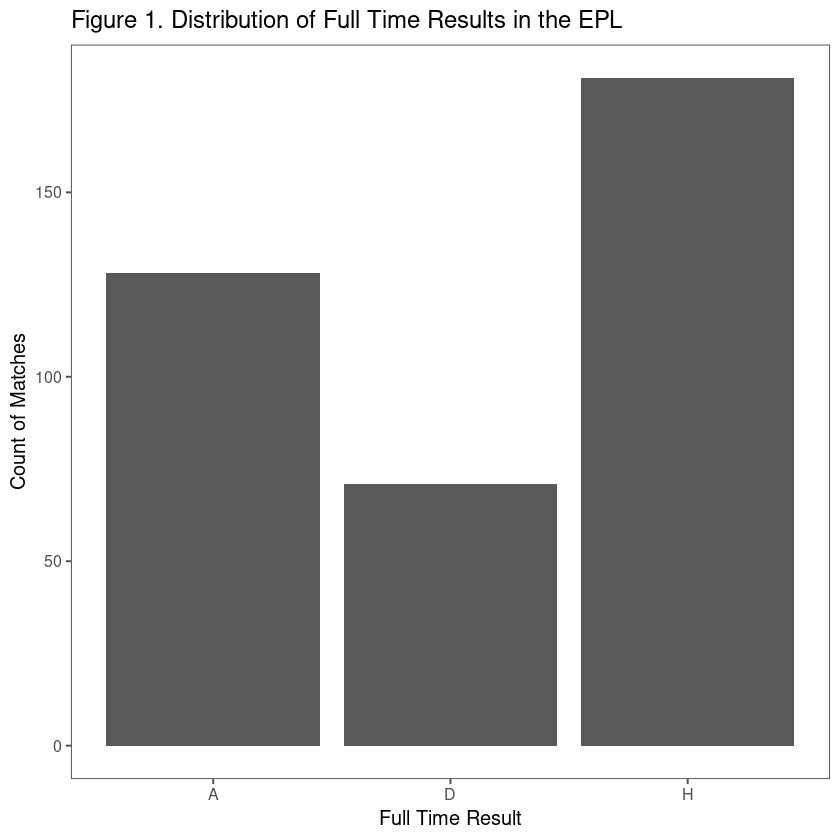

In [19]:
ggplot(data=soccer, aes(x=FTR)) +
	geom_bar() +
	labs(title="Figure 1. Distribution of Full Time Results in the EPL",
		x="Full Time Result",
		y="Count of Matches") +
	theme_few()

In [20]:
(percent_H <- sum(soccer$FTR == "H") / nrow(soccer) * 100)
(percent_A <- sum(soccer$FTR == "A") / nrow(soccer) * 100)
(percent_D <- sum(soccer$FTR == "D") / nrow(soccer) * 100)
chisq.test(table(soccer$FTR))

[1] 47.63158

[1] 33.68421

[1] 18.68421


	Chi-squared test for given probabilities

data:  table(soccer$FTR)
X-squared = 47.784, df = 2, p-value = 4.205e-11


The most common full time result in the English Premier League is a home win. Specifically, 47.63% of matches ended in a home win, 33.68% of matches ended in an away win, and 18.68% of matches ended in a draw. The Chi-squared test confirms that this variation is not just due to random chance. Overall, there is a home-pitch advantage in the English Premier League. 

### 4.3 Half Time Goal Difference

In [21]:
soccer <- soccer %>%
	mutate(HTGD = HTHG - HTAG)
table <- table(soccer$FTR, soccer$HTGD, dnn=c("Full Time Result", "Home Team Half Time GD"))
print(table)

                Home Team Half Time GD
Full Time Result -3 -2 -1  0  1  2  3  4
               A  4 21 55 44  4  0  0  0
               D  0  0 13 42 16  0  0  0
               H  0  3 10 62 65 31  9  1


In [22]:
for (j in 1:ncol(table)) {
	if (j %in% c(1,2,3)) {
		for (i in 1:nrow(table)) {
			table[i,j] <- table[i,j] / sum(as.vector(table[,j]))
			table[i,j] <- round(table[i,j]*100,2)
		}
	} else if (j == 4) {
		for (i in 1:nrow(table)) {
			table[i,j] <- table[i,j] / sum(as.vector(table[,j]))
			table[i,j] <- round(table[i,j]*100,2)
		}
	} else {
		for (i in 1:nrow(table)) {
			table[i,j] <- table[i,j] / sum(as.vector(table[,j]))
			table[i,j] <- round(table[i,j]*100,2)
		}
	}
}
print(table)

                Home Team Half Time GD
Full Time Result     -3     -2     -1      0      1      2      3      4
               A 100.00  87.50  70.51  29.73   4.71   0.00   0.00   0.00
               D   0.00   0.00  13.90  31.41  18.67   0.00   0.00   0.00
               H   0.00   3.31  10.59  50.35  73.55 100.00 100.00 100.00


The first table above is a cross-tabulation between full time result (home win, away win, or draw) and the goal difference at half time in terms of the home team. For example, a home team half time goal difference of 2 means that the home team is winning by two goals and a goal difference of -1 means that the home team is losing by one goal. To better aid interpretation, the second table above displays the information in the first table in terms of percentages. For example, the 1st row and the 4th column has a value of 29.73%. This indicates that 29.73% of matches with a half time goal difference of 0 ended in an away win. 

The above tables demonstrate the importance of both home/away team status and the goal difference at half time. If a team is the home team and winning by more than two goals, they are nearly certain to win the match (100% of matches in this situation ended in a home win). The same applies if a team is the away team and winning by three goals at half time. If the team is the away team and winning by two goals at half time, they can have high confidence that they will win the game (87.50% of matches ended this way). If a team is winning by 1 goal at half time, they can have moderate confidence that they will win the game, regardless of whether they are the home team or the away team (~70% of matches ended this way). Finally, if a match is tied at half time, there is a 50.35% chance that the home team will win. 

### 4.4 Beginning vs. End of Season

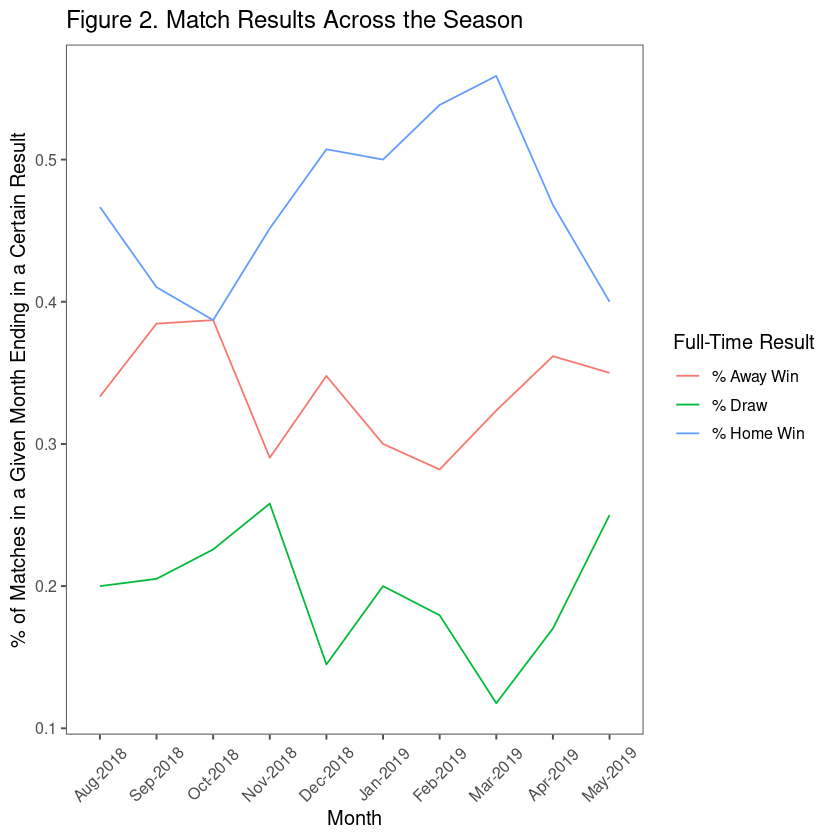

In [23]:
results_over_time <- soccer %>%
	select(Month, FTR)

# Cleaning date variable to "Month-Year" format for neater plotting
results_over_time$Month[results_over_time$Month==8] <- format(as.Date('2018-08-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==9] <- format(as.Date('2018-09-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==10] <- format(as.Date('2018-10-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==11] <- format(as.Date('2018-11-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==12] <- format(as.Date('2018-12-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==1] <- format(as.Date('2019-01-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==2] <- format(as.Date('2019-02-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==3] <- format(as.Date('2019-03-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==4] <- format(as.Date('2019-04-01'), '%b-%Y')
results_over_time$Month[results_over_time$Month==5] <- format(as.Date('2019-05-01'), '%b-%Y')

results_over_time$Month <- factor(results_over_time$Month, levels=c(format(as.Date('2018-08-01'), '%b-%Y'),
																   format(as.Date('2018-09-01'), '%b-%Y'),
																   format(as.Date('2018-10-01'), '%b-%Y'),
																   format(as.Date('2018-11-01'), '%b-%Y'),
																   format(as.Date('2018-12-01'), '%b-%Y'),
																   format(as.Date('2019-01-01'), '%b-%Y'),
																   format(as.Date('2019-02-01'), '%b-%Y'),
																   format(as.Date('2019-03-01'), '%b-%Y'),
																   format(as.Date('2019-04-01'), '%b-%Y'),
																   format(as.Date('2019-05-01'), '%b-%Y')))

# Calculating % HTR grouped by month
results_over_time <- results_over_time %>%
	mutate(D = 0,
		  A = 0, 
		  H = 0)
results_over_time$D[results_over_time$FTR=='D'] <- 1
results_over_time$A[results_over_time$FTR=='A'] <- 1
results_over_time$H[results_over_time$FTR=='H'] <- 1
results_over_time <- results_over_time %>%
	group_by(Month) %>%
	summarise(percent_D = sum(D) / (sum(D) + sum(A) + sum(H)),
		  percent_A = sum(A) / (sum(D) + sum(A) + sum(H)),
		  percent_H = sum(H) / (sum(D) + sum(A) + sum(H))) %>%
	pivot_longer(!Month, names_to="result", values_to="percent") %>%
	mutate(result = factor(result))

ggplot(results_over_time, aes(x=Month, y=percent, group=result, color=result)) +
	geom_line() +
	labs(title="Figure 2. Match Results Across the Season",
		x="Month",
		y="% of Matches in a Given Month Ending in a Certain Result",
		color="Full-Time Result") +
	scale_color_discrete(labels=c("% Away Win", "% Draw", "% Home Win")) +
	theme_few() +
	theme(axis.text.x = element_text(angle=45, vjust=0.5))
		

It is plausible that whether a match will end in a home win, away win, or a draw will vary by point in the season. In the beginning of the season, teams may settle for a draw, happy to get a single point from a game. At the end of a season, teams may push for a win, with championships and relegation on the line.

The data shows that this is not the case. Regardless of month, the modal full-time result is a Home win, followed by an Away win, and then a Draw. Month is **not** a factor that the coach should take into consideration when predicting full-time result from half-time result. 

### 4.5 Predictive Model (Decision Tree for Classification)

The final step in this analysis is building a predictive model. A predictive model leverages all possible features, rather than just considering one or a few at a time (as was done in the previous analytical steps). For this project, I will use a _decision tree_ for classificaton. A decision tree is the optimal model choice in this situation for a couple reasons. First, the logic behind a decision tree is intuitive for a non-technical audience. Second, a decision tree, but incorporating nested if/else statements, closely mimics human reasoning. Third, decision trees require minimal tunining (although in this analysis I will use pruning).

Oftentimes researchers will group multiple decision trees together into an ensemble (random forest, boosted tree, etc.). However, in this analysis I will only "grow" a single decision tree. The reason is that a single decision tree is easily visualizable, while ensemble methods are not. A single decision tree will result in a flowchart, that the coach can easily follow at half-time based on the characteristics of the game to make a deciison about what the full time result will be. 

#### 4.5.1 Building the Model

In [24]:
# Splitting data into a training set and a testing set
set.seed(911)
index <- sample(1:nrow(soccer), 2/3*nrow(soccer))
soccer_train <- soccer[index,]
soccer_train <- soccer_train %>%
	select(FTR,
		   Month,
		   HomeTeam,
		   AwayTeam,
		   HTHG,
		   HTAG,
		   HTR,
		   Referee,
		   HS,
		   AS,
		   HST,
		   AST,
		   HF,
		   AF,
		   HC,
		   AC,
		   HY,
		   AY,
		   HR,
		   AR)
soccer_test <- soccer[-index,]
soccer_test <- soccer_test %>%
	select(FTR,
		   Month,
		   HomeTeam,
		   AwayTeam,
		   HTHG,
		   HTAG,
		   HTR,
		   Referee,
		   HS,
		   AS,
		   HST,
		   AST,
		   HF,
		   AF,
		   HC,
		   AC,
		   HY,
		   AY,
		   HR,
		   AR)

# Single decision tree
single_tree <- tree(FTR ~ ., data=soccer_train)
summary(single_tree)


Classification tree:
tree(formula = FTR ~ ., data = soccer_train)
Variables actually used in tree construction:
[1] "HTR"      "HomeTeam" "AwayTeam" "Referee"  "HTAG"     "AST"      "HS"      
Number of terminal nodes:  24 
Residual mean deviance:  0.3968 = 90.86 / 229 
Misclassification error rate: 0.09091 = 23 / 253 

The first step is building a single decision tree on 70% of the data (the training set). The resulting tree only requires half time result, home team, away team, referee, half time away goals, away shots on target, and home shots to predict full time result. The tree predicts well, with a classification rate of 91% on the training data (of course, this is an overestimate of the actual classification rate). The next step is to use cost-complexity pruning with cross-validation in order to improve predictive performance on data the model has not yet seen. This often makes the tree more interpretable by reducing the number of terminal nodes.

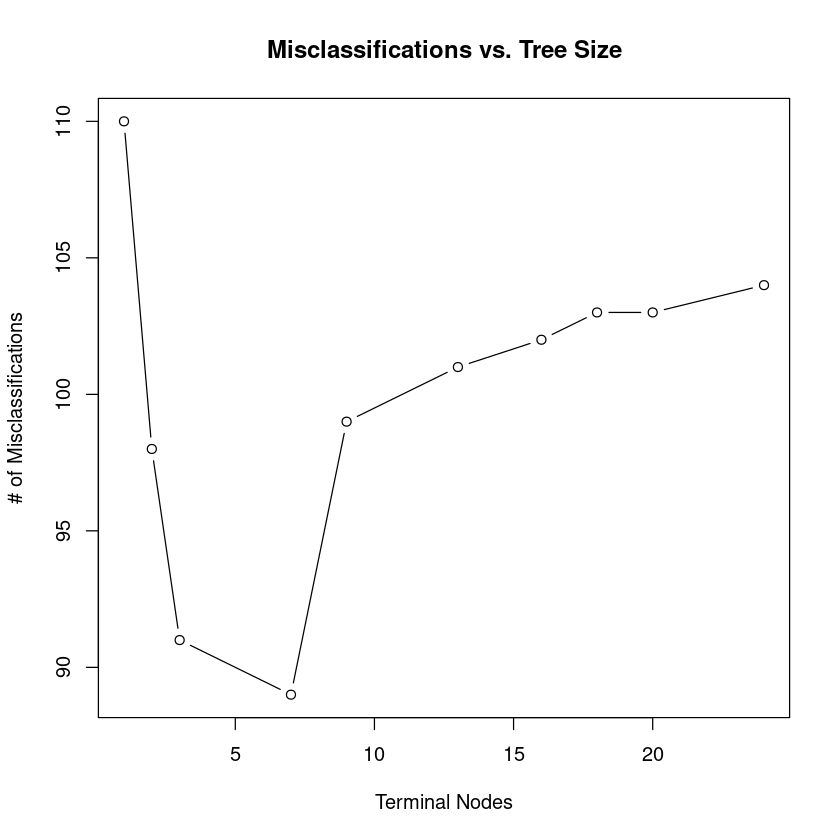

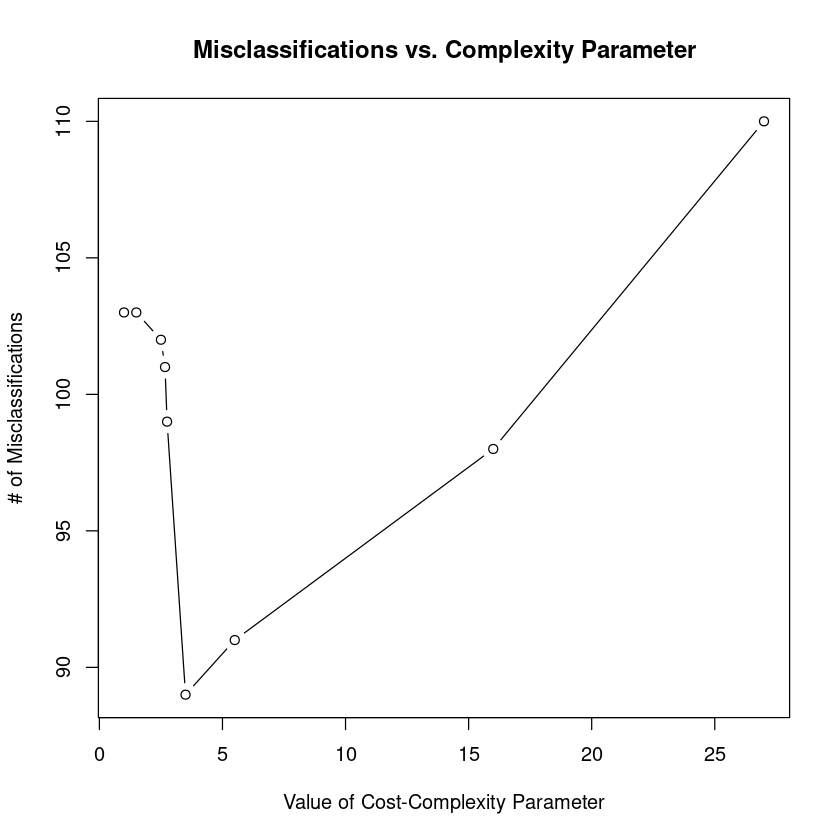

In [25]:
cv_soccer <- cv.tree(single_tree, FUN = prune.misclass) # prune.misclass uses misclassifications to guide pruning rather than deviance
plot(cv_soccer$size, cv_soccer$dev, type="b",
	main="Misclassifications vs. Tree Size",
	ylab="# of Misclassifications",
	xlab="Terminal Nodes")
plot(cv_soccer$k, cv_soccer$dev, type="b",
	main="Misclassifications vs. Complexity Parameter",
	ylab="# of Misclassifications",
	xlab="Value of Cost-Complexity Parameter")

The pruning process with cross-validation results in an optimal tree with seven terminal nodes. This is less than the 24 terminal nodes on the initial decision tree. This initial tree is overtrained on the data. The pruned tree, with less terminal nodes, will outperform the initial tree on new data. 


Classification tree:
snip.tree(tree = single_tree, nodes = c(44L, 20L, 3L, 4L, 23L
))
Variables actually used in tree construction:
[1] "HTR"      "Referee"  "AwayTeam" "HomeTeam"
Number of terminal nodes:  7 
Residual mean deviance:  1.326 = 326.2 / 246 
Misclassification error rate: 0.2411 = 61 / 253 

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 253 512.50 H ( 0.32806 0.16996 0.50198 )  
   2) HTR: A,D 165 343.90 A ( 0.47879 0.20606 0.31515 )  
     4) HTR: A 72 112.60 A ( 0.72222 0.15278 0.12500 ) *
     5) HTR: D 93 197.40 H ( 0.29032 0.24731 0.46237 )  
      10) Referee: A Madley,J Moss,L Probert,M Dean,P Tierney,R East,S Attwell,S Hooper 30  41.05 H ( 0.43333 0.00000 0.56667 )  
        20) AwayTeam: Arsenal,Cardiff,Chelsea,Crystal Palace,Leicester,Liverpool,Man City,Man United,Tottenham 20  25.90 A ( 0.65000 0.00000 0.35000 ) *
        21) AwayTeam: Burnley,Everton,Fulham,Southampton,West Ham 10   0.00 H ( 0.00000 0.00000 1.00000 ) *
      11) Referee: A Marriner,A Taylor,C Kavanagh,C Pawson,D Coote,G Scott,K Friend,L Mason,M Atkinson,M Oliver 63 134.50 H ( 0.22222 0.36508 0.41270 )  
        22) HomeTeam: Bournemouth,Brighton,Burnley,Crystal Palace,Huddersfield,Man United,Southampton,Wolves 25  48.84 A ( 0.44000 0.44000 0.12000 )  
        

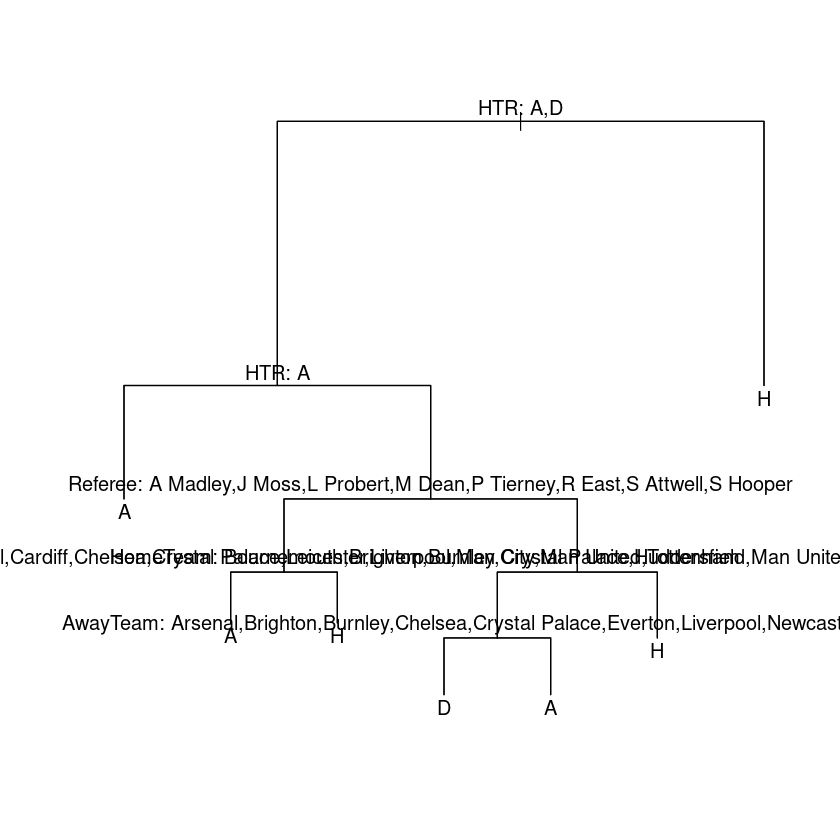

In [26]:
pruned_tree <- prune.misclass(single_tree, best=7)
summary(pruned_tree)
plot(pruned_tree)
text(pruned_tree, pretty=0)
pruned_tree

model <- pruned_tree # saving final model as "model"

The final model is displayed above. As the model visualization shows, a single decision tree is akin to a flowchart. The visualization is slightly messy at points, especially when trying to show teams at a split (this is due to there being 20 teams). To aid interpretation, I have also provided a text-based tree.

The first and second split in the tree are on the result at half time. This means that, out of all the features in the data, half time result is the most important feature in prediciting full time result. The tree predicts the full time result to be the same as the half time result, when the half time result is a home lead or an away lead. When the half time result is a draw, the tree then looks to other features like referee and team. Ultimately, the tree uses the following to predict full time result: half time result, referee, home team, and away team. The classification rate for this model on the training data is 75.9%. But, how does this model perform on data it has not yet seen?

#### 4.5.2 Testing the Model

In [27]:
predictions <- predict(model, soccer_test, type="class")
observations <- soccer_test[["FTR"]]
(table <- table(predictions, observations))
sum(diag(table)) / sum(table) # Classification rate

           observations
predictions  A  D  H
          A 33  8  7
          D  2  2  1
          H 10 18 46

[1] 0.6377953

Above is a table displaying the model predictions on the test set (the 30% of the data the model has not seen) and the actual observations from the test set. This pruned decison tree correctly predicts the full time result 63.78% of the time given certain match statistics at half time. This relatively low classification rate is not unsurprising; sport is, after all, a very unpredictable affair (which partly explains its popularity) and this model is still more informative than simply flipping a coin. Diving more into the predictions should provide insight into where the model breaks down. 

In [28]:
diag(table)[1] / sum(table[,1]) # Accuracy on away win predictions
diag(table)[2] / sum(table[,2]) # Accuracy on draw predictions
diag(table)[3] / sum(table[,3]) # Accuracy on home win predictions

A 
0.7333333

D 
0.07142857

H 
0.8518519

The above calculations are the classification rates given a model's prediction for full time result. When the model predicts a home win it is accurate 85% of the time. When the model predicts an away win, it is accurate 73% of the time. However, the model is exceptionally innacurate when it predicts a draw at full time. It is only accurate 7.14% of the time. In other words, it predicts worse than random chance. The low overall classification rate is driven by the model's innacuracy when predicting a draw at full time. Whether the coach relies on the model or not should be conditional on its predicted full time result.

## 5. Findings and Conclusion

The analysis reveals the following:

1. Half time result is indeed related to full time result
2. There is a home field advantage in the English Premier League
3. Looking at the interaction of these two (half time result and home team status) is even more informative
4. Point in the season (i.e., month) is **not** related to the probability of a certain full time result.


These findings, as well as the information in the match statisics, is combined in a machine learning model trained to best predict full time result. The model is a decision tree for classification, which visualizes as a flowchart that a non-technical coach can follow. The model produces mixed results overall (a classification accuracy of 63.78% on the test set). But, this is becuase the model is very innaccurate when it predicts a draw at full time. If the model predicts a home win at full time, the coach can have confidence in this prediction. If the model predicts an away win, the coach can have moderate confidence in this prediction. 

Individual soccer matches, especially in the English Premier League, are highly unpredictable. This partly explains their global popularity. However, this analysis was able to ascertain some patterns that can be used to predict full time result from half time result with moderate confidence. The information from this research, combined with the coach's subject matter expertise, will optimize the amount of development time for the newly-signed young players. 